# Verificando o funcionamento do sistema em tempo real

Esse jupyter é igualzinho o que gera o sistema pra rodar em tempo real. A diferença é que ao invés de ouvir o som ambiente eu vou tentar processar o WAV do treinamento usando o sistema de tempo real pra ver se ele chega em acurácia alta msm.

In [1]:
import sys
import pyaudio
import numpy as np
import warnings
import wave
import threading
import matplotlib.pyplot as plt
from IPython.display import Audio
from random import randint
from time import time, sleep

sys.path.append("/home/pi/Programming/IC2019/Raspberry/Python/")

from delayAndSum import delayAndSum as DaS
from extracaoFeatures import extrairFeaturesUnicoFrame as ExtrairFeatures
from iniciarNormalizadorEClassificador import main as IniciarObjetos

warnings.filterwarnings("ignore")

/home/pi/.pyenv/versions/3.6.1/envs/venv1/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


### Verificando o dispositivo que vamos usar pra gravar

In [2]:
def listarDispositivos():
    p = pyaudio.PyAudio()
    info = p.get_host_api_info_by_index(0)
    numdevices = info.get('deviceCount')

    for i in range(0, numdevices):
        if (p.get_device_info_by_host_api_device_index(0, i).get('maxInputChannels')) > 0:
            print("Input Device id ", i, " - ", p.get_device_info_by_host_api_device_index(0, i).get('name'))

In [3]:
listarDispositivos()

Input Device id  0  -  seeed-4mic-voicecard: bcm2835-i2s-ac10x-codec0 ac10x-codec.1-003b-0 (hw:1,0)
Input Device id  3  -  ac108


### Definição de funções

In [4]:
def processarJanelaCompleta(idJanela, metadeInicialJanelaAtual, metadeFinalJanelaAtual):
    
    stringID = "(id:" + str(idJanela) + ")"
    inicioProcessamento = time()
    dictGlobal[str(idJanela)]["inicioProcessamento"] = inicioProcessamento
    print(stringID, "Iniciando o processamento. Timestamp:", inicioProcessamento)    
    
    # COPIANDO OS ARRAYS NA MEMORIA PRA GARANTIR QUE NAO VAI DAR BOSTA
    metadeInicial = np.copy(metadeInicialJanelaAtual)
    metadeFinal   = np.copy(metadeFinalJanelaAtual)
    
    # CONVERTO A JANELA PRA FLOAT
    janelaFloat_A = np.frombuffer(metadeInicial, dtype=np.int16).astype("float")
    janelaFloat_B = np.frombuffer(metadeFinal, dtype=np.int16).astype("float")
    
    # COMO TEM OS 4 MICS NA JANELA, VOU DAR UM RESHAPE PRA CADA MIC FICAR EM UMA LINHA
    janelaFloat_A = janelaFloat_A.reshape((metadeTamanhoJanela, qtdCanais)).T   
    janelaFloat_B = janelaFloat_B.reshape((metadeTamanhoJanela, qtdCanais)).T
    
    # DELAY AND SUM
    sinalDaS_A = DaS(janelaFloat_A)
    sinalDaS_B = DaS(janelaFloat_B)
    
    # JUNTO AS METADES
    janelaCompleta = np.concatenate((sinalDaS_A, sinalDaS_B))
    
    # SALVANDO NO DICIONARIO PRA FAZER CLASSS OFFLINE
    dictGlobal[str(idJanela)]["sinal"] = janelaCompleta
    
    # EXTRACAO DE FEATURES
    features = ExtrairFeatures(janelaCompleta, freqAmostragem)

    # NORMALIZANDO AS FEATURES
    features = objNormalizador.transform([features])[0]

    # CLASSIFICACAO
    predicao = objClassificador.predict([features])[0]
    
    dictGlobal[str(idJanela)]["classificacao"] = predicao
    fimProcessamento = time()
    dictGlobal[str(idJanela)]["fimProcessamento"] = fimProcessamento
    print(stringID, "Classificado como", predicao)
    print(stringID, "Processamento finalizado. Timestamp:", fimProcessamento)

### Parâmetros iniciais

In [5]:
idDispositivoGravacao = 0
tempoJanela           = 0.500
freqAmostragem        = 16000
profundidadeBytes     = 2
qtdCanais             = 1
caminhoCSVDataset     = "/home/pi/Datasets/ESC_3_ReSpeaker_1595612342.0004687/500ms.csv"

In [6]:
objClassificador, objNormalizador = IniciarObjetos(caminhoCSVDataset, classificador=None, verbose=True)

Carregando o CSV do dataset
CSV carregado
Separando o que é data e target
Iniciando objeto normalizador
Treinando objeto normalizador
Normalizando os dados de treinamento
Instanciando objeto classificador
Treinando o classificador
objClassificador e objNormalizador prontos: operação finalizada.


### Rodando

In [7]:
# DEFININDO QUAL WAV EU VOU LER
arquivoWAVDesejado = "/home/pi/Datasets/ESC_3_ReSpeaker_1595612342.0004687/audio/sneezing_000_1.wav"

# CRIANDO UM OBJETO WAV DO ARQUIVO QUE QUERO LER
objWF = wave.open(arquivoWAVDesejado, 'rb')

# VERIFICANDO QUANTAS JANELAS EU VOU GRAVAR
qtdAmostrasTotal     = objWF.getnframes()
qtdAmostrasPorJanela = freqAmostragem * tempoJanela
qtdJanelas           = int(qtdAmostrasTotal / qtdAmostrasPorJanela)
metadeTamanhoJanela  = int(qtdAmostrasPorJanela/2)

# LOOP
idJanela            = 1
executarAteIdJanela = qtdJanelas
dictGlobal          = {}
tempoReferencia     = time()
while idJanela < executarAteIdJanela:
    
    # GRAVANDO
    janelasParciais = []
    for i in range(5):
        
        if i == 0:
            dictGlobal[str(idJanela)] = {"inicioGravacao": time()}
            janelasParciais.append(objWF.readframes(metadeTamanhoJanela))            
            idJanela += 1  
            sleep(tempoJanela/4) # DELAY PRA SIMULAR O TEMPO DE GRAVACAO EM TEMPO REAL
        elif i == 1:
            dictGlobal[str(idJanela)] = {"inicioGravacao": time()}
            janelasParciais.append(objWF.readframes(metadeTamanhoJanela))
            dictGlobal[str(idJanela-1)]["fimGravacao"] = time()
            objThread = threading.Thread(target=processarJanelaCompleta, args=(idJanela-1, janelasParciais[i-1], janelasParciais[i]))
            objThread.start()            
            idJanela += 1
            sleep(tempoJanela/4) # DELAY PRA SIMULAR O TEMPO DE GRAVACAO EM TEMPO REAL
        elif i == 2:
            dictGlobal[str(idJanela)] = {"inicioGravacao": time()}
            janelasParciais.append(objWF.readframes(metadeTamanhoJanela))
            dictGlobal[str(idJanela-1)]["fimGravacao"] = time()
            objThread = threading.Thread(target=processarJanelaCompleta, args=(idJanela-1, janelasParciais[i-1], janelasParciais[i]))
            objThread.start()            
            idJanela += 1
            sleep(tempoJanela/4) # DELAY PRA SIMULAR O TEMPO DE GRAVACAO EM TEMPO REAL
        elif i == 3:
            dictGlobal[str(idJanela)] = {"inicioGravacao": time()}
            janelasParciais.append(objWF.readframes(metadeTamanhoJanela))
            dictGlobal[str(idJanela-1)]["fimGravacao"] = time()
            objThread = threading.Thread(target=processarJanelaCompleta, args=(idJanela-1, janelasParciais[i-1], janelasParciais[i]))
            objThread.start()
            sleep(tempoJanela/4) # DELAY PRA SIMULAR O TEMPO DE GRAVACAO EM TEMPO REAL
        else:
            janelasParciais.append(objWF.readframes(metadeTamanhoJanela))
            dictGlobal[str(idJanela)]["fimGravacao"] = time()
            objThread = threading.Thread(target=processarJanelaCompleta, args=(idJanela, janelasParciais[i-1], janelasParciais[i]))
            objThread.start()            
            idJanela += 1
            sleep(tempoJanela/4) # DELAY PRA SIMULAR O TEMPO DE GRAVACAO EM TEMPO REAL

# DELAYZINHO PRO PRINT FICAR NESSA CELULA
sleep(2.5)

(id:1) Iniciando o processamento. Timestamp: 1595640717.3342202
(id:2) Iniciando o processamento. Timestamp: 1595640717.4613373
(id:1) Classificado como sneezing
(id:1) Processamento finalizado. Timestamp: 1595640717.5351555
(id:3) Iniciando o processamento. Timestamp: 1595640717.590419
(id:2) Classificado como sneezing
(id:2) Processamento finalizado. Timestamp: 1595640717.7017274
(id:4) Iniciando o processamento. Timestamp: 1595640717.71696
(id:3) Classificado como sneezing
(id:3) Processamento finalizado. Timestamp: 1595640717.8293347
(id:4) Classificado como sneezing
(id:4) Processamento finalizado. Timestamp: 1595640717.9430795
(id:5) Iniciando o processamento. Timestamp: 1595640717.968835
(id:6) Iniciando o processamento. Timestamp: 1595640718.0952415
(id:5) Classificado como sneezing
(id:5) Processamento finalizado. Timestamp: 1595640718.1682546
(id:7) Iniciando o processamento. Timestamp: 1595640718.2216508
(id:6) Classificado como sneezing
(id:6) Processamento finalizado. Time

### Printando

In [8]:
def corAleatoria():
    return "#" + str(randint(10,99)) + str(randint(10,99)) + str(randint(10,99))

In [9]:
#DEFININDO ALGUNS PARÂMETROS DO GRÁFICO
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
params = {
    'figure.figsize': [10,10], 
    'axes.labelsize': 14,
    'axes.titlesize':18, 
    'font.size': 18,
    'legend.fontsize': 12, 
    'xtick.labelsize': 10, 
    'ytick.labelsize': 10,
    'axes.axisbelow': True
}
plt.rcParams.update(params)

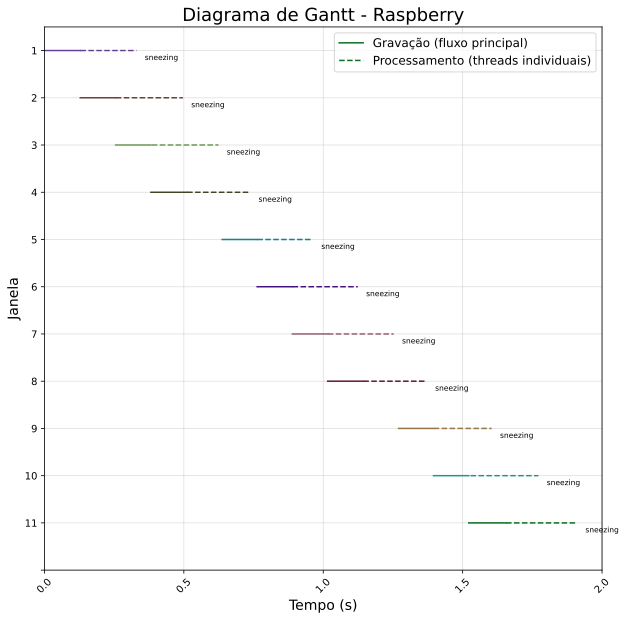

In [10]:
caminhoSalvar = "/home/pi/Programming/IC2019/Raspberry/Resultados/"
yTicks = []

for i, chave in enumerate(dictGlobal):
    
    if i == len(dictGlobal)-1:
        continue
    
    # AJUSTANDO O EIXO X DA ITERACAO ATUAL
    inicioGravacao      = dictGlobal[chave]["inicioGravacao"] - tempoReferencia
    fimGravacao         = dictGlobal[chave]["fimGravacao"] - tempoReferencia
    inicioProcessamento = dictGlobal[chave]["inicioProcessamento"] - tempoReferencia
    fimProcessamento    = dictGlobal[chave]["fimProcessamento"] - tempoReferencia
    classificacao       = dictGlobal[chave]["classificacao"]
    
    # DEFININDO A COR
    corAtual = corAleatoria()
    
    # COLOCANDO A ITERACAO ATUAL NO YTICKS
    yTicks.append(chave)
    
    # PLOTANDO
    plt.plot([inicioGravacao, fimGravacao], [i, i], "-", color=corAtual)
    plt.plot([inicioProcessamento, fimProcessamento], [i, i], "--", color=corAtual)
    plt.text(fimProcessamento+3e-2, i+0.2, classificacao, fontsize=7.5)

# CRIANDO A LEGENDA
plt.plot([fimProcessamento,fimProcessamento],[i-1,i-1], "-", label="Gravação (fluxo principal)", color=corAtual)
plt.plot([fimProcessamento,fimProcessamento],[i-1,i-1], "--", label="Processamento (threads individuais)", color=corAtual)

# AJUSTANDO MAIS PARAMETROS
plt.title("Diagrama de Gantt - Raspberry")
plt.ylabel("Janela")
plt.xlabel("Tempo (s)")
plt.legend()
plt.xlim(0, fimProcessamento)
plt.xticks(ticks=np.arange(0, fimProcessamento+tempoJanela, tempoJanela), rotation=45)
plt.yticks(ticks=np.arange(0, i+1), labels=yTicks)
plt.gca().invert_yaxis()
plt.grid(alpha=0.4)
plt.savefig(caminhoSalvar+"diagramaGantt_raspberry.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [11]:
dictGlobal

{'1': {'inicioGravacao': 1595640717.2083304,
  'fimGravacao': 1595640717.3337576,
  'inicioProcessamento': 1595640717.3342202,
  'sinal': array([-1475.,  -793.,   767., ...,   818.,  1501.,   548.]),
  'classificacao': 'sneezing',
  'fimProcessamento': 1595640717.5351555},
 '2': {'inicioGravacao': 1595640717.3336241,
  'fimGravacao': 1595640717.4607816,
  'inicioProcessamento': 1595640717.4613373,
  'sinal': array([ -521.,   254., -2989., ...,  1140.,  1793.,   661.]),
  'classificacao': 'sneezing',
  'fimProcessamento': 1595640717.7017274},
 '3': {'inicioGravacao': 1595640717.4605973,
  'fimGravacao': 1595640717.5872986,
  'inicioProcessamento': 1595640717.590419,
  'sinal': array([ 2212.,   469.,  -738., ...,   669.,   443., -1342.]),
  'classificacao': 'sneezing',
  'fimProcessamento': 1595640717.8293347},
 '4': {'inicioGravacao': 1595640717.5871234,
  'fimGravacao': 1595640717.716498,
  'inicioProcessamento': 1595640717.71696,
  'sinal': array([-2348.,  3393., -5606., ..., -1622., 

## Tentando classificar sem ser em tempo real

In [12]:
# PARA CADA JANELA GRAVADA
for idJanela in range(1, executarAteIdJanela+1, 1):
    
    
    # PEGO O SINAL QUE FOI GRAVADO
    sinalAtual = dictGlobal[str(idJanela)]['sinal']
    
    # EXTRACAO DE FEATURES
    features = ExtrairFeatures(sinalAtual, freqAmostragem)

    # NORMALIZANDO AS FEATURES
    features = objNormalizador.transform([features])[0]

    # CLASSIFICACAO
    predicao = objClassificador.predict([features])[0]
    
    # RESULTADO
    print(idJanela, "-> Classificação offline:", dictGlobal[str(idJanela)]['classificacao'], "-> classificação online:", predicao)

1 -> Classificação offline: sneezing -> classificação online: sneezing
2 -> Classificação offline: sneezing -> classificação online: sneezing
3 -> Classificação offline: sneezing -> classificação online: sneezing
4 -> Classificação offline: sneezing -> classificação online: sneezing
5 -> Classificação offline: sneezing -> classificação online: sneezing
6 -> Classificação offline: sneezing -> classificação online: sneezing
7 -> Classificação offline: sneezing -> classificação online: sneezing
8 -> Classificação offline: sneezing -> classificação online: sneezing
9 -> Classificação offline: sneezing -> classificação online: sneezing
10 -> Classificação offline: sneezing -> classificação online: sneezing


## Ouvindo algumas amostras

In [13]:
Audio(data=dictGlobal['1']['sinal'], rate=freqAmostragem)

In [14]:
sinalConcatenado = []
for i in range(1, executarAteIdJanela, 2):
    sinalConcatenado.extend(dictGlobal[str(i)]['sinal'])
Audio(data=sinalConcatenado, rate=freqAmostragem)